**Description:** This code loads the combined dataset and develops an Elman Neural Network (ENN) to identify crop health, saving the trained model as enn_model.h5. This trained model is then used as the environment by the Deep Q-Network (DQN) to determine the optimal actions. A valid path to the dataset and the location for saving the model must be provided.

In [2]:
# === 1. Import Required Libraries ===
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score, roc_curve
)
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === 2. Load Dataset ===
data_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/Combined_Data.csv"
combined_dataset = pd.read_csv(data_path)

# === 3. Prepare Features and Labels ===
features = ['N', 'P', 'K', 'Temp', 'H', 'pH', 'R', 'WL']
X = combined_dataset[features]
y = combined_dataset['CH']

# === 4. Scale Features ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === 5. Balance Dataset with SMOTE ===
sm = SMOTE(random_state=42)
X_balanced, y_balanced = sm.fit_resample(X_scaled, y)

# === 6. Reshape for RNN ===
X_balanced_reshaped = X_balanced.reshape((X_balanced.shape[0], 1, X_balanced.shape[1]))

# === 7. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_balanced_reshaped, y_balanced, test_size=0.2, random_state=42)

# === 8. Model Builder for Tuning ===
def build_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('units', [16, 32, 64, 128]),
        activation=hp.Choice('activation', ['tanh', 'relu']),
        input_shape=(1, X.shape[1])
    ))
    model.add(Dropout(rate=hp.Choice('dropout', [0.0, 0.2, 0.3])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [0.001, 0.0005, 0.0001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# === 9. Run Keras Tuner ===
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=8,
    executions_per_trial=1,
    overwrite=True,
    directory='enn_tuning',
    project_name='crop_health_tuned'
)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

# === 10. Best Model ===
best_hp = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hp)

# === 11. Train and Evaluate Model Manually ===
EPOCHS = 500
batch_size = 32
patience = 10
best_f1 = 0
patience_counter = 0

acc_list = []
prec_list = []
rec_list = []
f1_list = []
auc_list = []
loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []
roc_data = {}
confusion_matrices = {}

for epoch in range(EPOCHS):
    history_epoch = model.fit(X_train, y_train, batch_size=batch_size, epochs=1, validation_split=0.2, verbose=0)

    # Store loss and accuracy from history
    loss_list.append(history_epoch.history['loss'][0])
    val_loss_list.append(history_epoch.history['val_loss'][0])
    train_acc_list.append(history_epoch.history['accuracy'][0])
    val_acc_list.append(history_epoch.history['val_accuracy'][0])

    # Evaluate on test set after each epoch
    y_pred = (model.predict(X_test, verbose=0) >= 0.5).astype(int)
    y_pred_proba = model.predict(X_test, verbose=0).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)
    auc_list.append(auc)

    # Save confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[epoch + 1] = cm

    # Save ROC data for certain AUC values
    for target_auc in [0.75, 0.85, 0.95]:
        if round(auc, 3) == round(target_auc, 3) and target_auc not in roc_data:
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_data[target_auc] = (fpr, tpr)

    # Print progress
    if patience_counter < patience:
        print(f"Epoch {epoch+1}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1 Score={f1:.4f}")

    # Early stopping logic
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
    else:
        patience_counter += 1

# === 12. Store All Epoch-based Metrics ===
metrics_df = pd.DataFrame({
    'Epoch': range(1, EPOCHS + 1),
    'Train_Loss': loss_list,
    'Val_Loss': val_loss_list,
    'Train_Acc': train_acc_list,
    'Val_Acc': val_acc_list,
    'Accuracy': acc_list,
    'Precision': prec_list,
    'Recall': rec_list,
    'F1Score': f1_list,
    'AUC': auc_list
})

# === 13. Extract AUC Threshold Matches ===
selected_aucs = metrics_df[metrics_df['AUC'].isin([0.75, 0.85, 0.95])]
print("\n Epochs where AUC matches target values:")
print(selected_aucs)

# === 14. Final Performance ===
y_pred_final = (model.predict(X_test, verbose=0) >= 0.5).astype(int)
y_pred_final_proba = model.predict(X_test, verbose=0).flatten()

# Save final ROC data
fpr_final, tpr_final, _ = roc_curve(y_test, y_pred_final_proba)
roc_data['Final'] = (fpr_final, tpr_final)

print("\n Best Hyperparameters:")
print(best_hp.values)

print("\n Final Test Performance:")
print(f"Accuracy  : {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision : {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall    : {recall_score(y_test, y_pred_final):.4f}")
print(f"F1 Score  : {f1_score(y_test, y_pred_final):.4f}")
print(f"AUC Score : {roc_auc_score(y_test, y_pred_final_proba):.4f}")

# === 15. Save All History ===
history = {
    "metrics_df": metrics_df,
    "roc_data": roc_data,
    "confusion_matrices": confusion_matrices
}


Trial 8 Complete [00h 00m 06s]
val_accuracy: 0.9029957056045532

Best val_accuracy So Far: 0.9857346415519714
Total elapsed time: 00h 00m 49s
INFO:tensorflow:Oracle triggered exit
Epoch 1: Accuracy=0.7489, Precision=0.6809, Recall=0.8843, F1 Score=0.7694
Epoch 2: Accuracy=0.8596, Precision=0.8395, Recall=0.8699, F1 Score=0.8544
Epoch 3: Accuracy=0.8813, Precision=0.8783, Recall=0.8699, F1 Score=0.8741
Epoch 4: Accuracy=0.8916, Precision=0.8941, Recall=0.8747, F1 Score=0.8843
Epoch 5: Accuracy=0.8927, Precision=0.8943, Recall=0.8771, F1 Score=0.8856
Epoch 6: Accuracy=0.9064, Precision=0.9215, Recall=0.8771, F1 Score=0.8988
Epoch 7: Accuracy=0.9075, Precision=0.9217, Recall=0.8795, F1 Score=0.9001
Epoch 8: Accuracy=0.9144, Precision=0.9293, Recall=0.8867, F1 Score=0.9075
Epoch 9: Accuracy=0.9167, Precision=0.9275, Recall=0.8940, F1 Score=0.9104
Epoch 10: Accuracy=0.9235, Precision=0.9508, Recall=0.8843, F1 Score=0.9164
Epoch 11: Accuracy=0.9247, Precision=0.9418, Recall=0.8964, F1 Score=

Epoch 141: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 142: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 154: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 155: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 156: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 157: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 158: Accuracy=0.9977, Precision=0.9952, Recall=1.0000, F1 Score=0.9976
Epoch 159: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 160: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 161: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 162: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964
Epoch 163: Accuracy=0.9966, Precision=0.9928, Recall=1.0000, F1 Score=0.9964

 Epochs where AUC matches target values:
Empty DataFrame
Columns: [Epoch, T

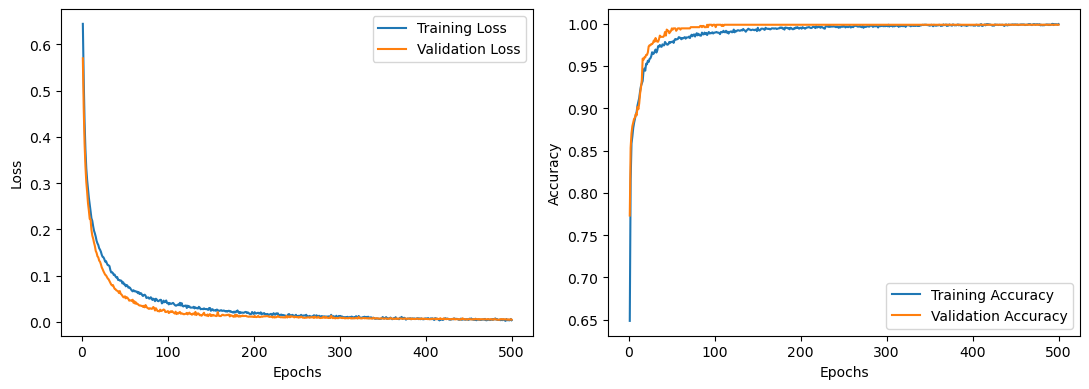

In [3]:
# === Plot: Training vs Validation Loss and Accuracy (500 Epochs) ===
plt.figure(figsize=(11, 4))

# --- Plot (a): Loss ---
plt.subplot(1, 2, 1)
plt.plot(metrics_df['Epoch'], metrics_df['Train_Loss'], label='Training Loss')
plt.plot(metrics_df['Epoch'], metrics_df['Val_Loss'], label='Validation Loss')
#plt.title('(a) Loss vs Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- Plot (b): Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(metrics_df['Epoch'], metrics_df['Train_Acc'], label='Training Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Val_Acc'], label='Validation Accuracy')
#plt.title('(b) Accuracy vs Epochs', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


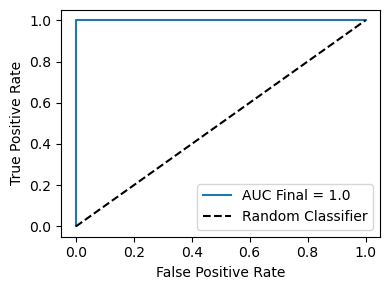

In [4]:
# === Plot ROC Curves for Different AUC Points ===
plt.figure(figsize=(4, 3))

# Plot each saved ROC curve
for label, (fpr, tpr) in roc_data.items():
    auc_value = round(np.trapz(tpr, fpr), 4)
    plt.plot(fpr, tpr, label=f'AUC {label} = {auc_value}')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Labels and title
#plt.title('ROC Curves at Different AUC Thresholds', fontsize=14)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
#plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


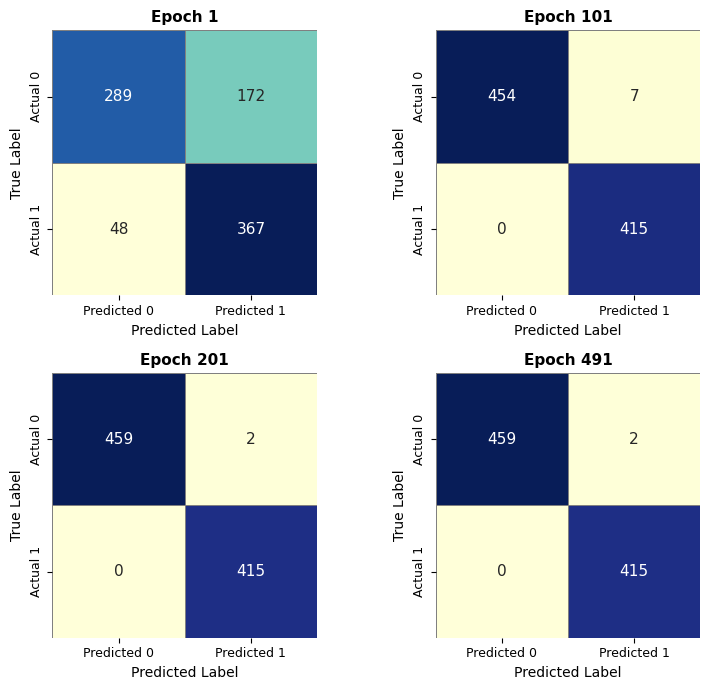

In [5]:
# --- Function to plot one confusion matrix in a subplot ---
def plot_confusion_matrices_grid(confusion_matrices, epochs_to_plot):
    fig, axs = plt.subplots(2, 2, figsize=(8, 7))
    axs = axs.flatten()

    for i, epoch in enumerate(epochs_to_plot):
        cm = confusion_matrices.get(epoch)
        if cm is not None:
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False, square=True,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                linewidths=0.5, linecolor='gray',
                annot_kws={"size": 11}, ax=axs[i]
            )
            axs[i].set_title(f'Epoch {epoch}', fontsize=11, weight='bold')
            axs[i].set_xlabel('Predicted Label', fontsize=10)
            axs[i].set_ylabel('True Label', fontsize=10)
            axs[i].tick_params(axis='both', labelsize=9)
        else:
            axs[i].set_visible(False)
            print(f"Confusion matrix not found for epoch {epoch}")

    plt.tight_layout()
    plt.show()

# === Call the plotting function ===
epochs_to_plot = [1, 101, 201, 491]
plot_confusion_matrices_grid(confusion_matrices, epochs_to_plot)


In [6]:
# === Save ENN Model to Specific Path ===
save_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/enn_model.h5"
model.save(save_path)
print(f" ENN model saved successfully at:\n{save_path}")


 ENN model saved successfully at:
/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/enn_model.h5


/Users/administrator/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# === Varify saved model ===

from tensorflow.keras.models import load_model
# === Load ENN Model from Specified Path ===
load_path = "/Users/administrator/Desktop/All desktop-data/Prof-Irshad Papers/2025-Papers/10K-Paper/Crop-IoT-Paper/IoT-Journal-Submission/Manuscript-R2/Code-For-Github/enn_model.h5"
enn_model = load_model(load_path)

# Verify the model
enn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 64)                4672      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
